In [18]:
import numpy as np
from utils.slam_helpers import transform_to_frame,transformed_params2depthplussilhouette,transformed_params2rendervar,transformed_GRNparams2rendervar,transformed_GRNparams2depthplussilhouette
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from scripts.main_SurgeSplat import deform_gaussians, setup_camera
import torch
import os
from PIL import Image

In [19]:
intrinsics = torch.tensor([[199.6883,   0.0000, 166.3290],
        [  0.0000, 249.4753, 170.4058],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')
w2c = torch.tensor([[ 1.0000e+00,  6.5711e-11,  2.3283e-10,  0.0000e+00],
        [-3.1832e-11,  1.0000e+00, -7.4115e-21,  0.0000e+00],
        [-9.2644e-22,  2.9104e-11,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

cam = setup_camera(336,336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=True)




In [20]:
params_np = np.load('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/experiments/EndoNerf cutting_deform_short/cutting_deform_short/params.npz')
params={}
for key in params_np.keys():
    params[key] = torch.tensor(params_np[key]).cuda()

In [21]:
params

{'means3D': tensor([[-0.8282, -0.6718,  0.9926],
         [-0.8254, -0.6934,  0.9728],
         [-0.8129, -0.6875,  0.9875],
         ...,
         [ 0.2499,  0.1741,  0.0966],
         [ 0.4022,  0.2008,  0.1837],
         [ 0.5082,  0.2172,  0.2801]], device='cuda:0'),
 'rgb_colors': tensor([[-0.0134, -0.3315, -0.1528],
         [ 0.6636,  0.4258,  0.6379],
         [ 0.5044,  0.2184,  0.2580],
         ...,
         [ 0.1037,  0.0292,  0.0154],
         [ 0.0389,  0.0021, -0.0224],
         [ 0.0634,  0.0251, -0.0110]], device='cuda:0'),
 'unnorm_rotations': tensor([[-0.1594,  0.1604,  0.0450, -0.1534],
         [-0.4229,  0.4863,  0.0411, -0.3992],
         [-0.5000,  0.6973, -0.0220, -0.4542],
         ...,
         [-0.0080, -0.0115,  0.0458, -0.1976],
         [ 0.0637,  0.0665,  0.1200, -0.2440],
         [ 0.0232,  0.1584,  0.1501, -0.2688]], device='cuda:0'),
 'logit_opacities': tensor([[-1.7029],
         [ 1.6766],
         [-5.7987],
         ...,
         [-2.0350],
     

In [22]:

def deform_gaussians(params,time,deform_grad):

    if deform_grad:
        weights = params['deform_weights']
        stds = params['deform_stds']
        biases = params['deform_biases']
    else:
        weights = params['deform_weights'].detach()
        stds = params['deform_stds'].detach()
        biases = params['deform_biases'].detach()

    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1) # Nx10 gaussians deformations
    deform_xyz = deform[:,:3]
    deform_rots = deform[:,3:7]
    deform_scales = deform[:,7:10]
    # print(f'xyz: {torch.sum(deform_xyz)}')
    # print(torch.sum(deform_rots).item())
    # print(torch.sum(deform_scales).item())
    xyz = params['means3D']+deform_xyz
    rots = params['unnorm_rotations']+deform_rots
    scales = params['log_scales']+deform_scales

    return xyz,rots,scales


for id in range(params['cam_unnorm_rots'].shape[-1]):
    local_means,local_rots,local_scales = deform_gaussians(params,id,deform_grad = True)


    #  print(torch.sum(local_means-params['means3D']))

    transformed_pts = transform_to_frame(local_means,params,id,False,False)





    # Initialize Render Variables
    rendervar = transformed_GRNparams2rendervar(params, transformed_pts,local_rots,local_scales)
    print(local_scales.max())
    rv_store = {}
    for key in rendervar.keys():
        rv_store[key] = rendervar[key].cpu().detach()
        local_means_store = local_means.cpu()
        local_scales_store = local_rots.cpu()
        local_rots_store = local_rots.cpu()
        transformed_pts_store = transformed_pts.cpu()



    #  rendervar['means3D'].retain_grad()
    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, w2c,
                                            transformed_pts,local_rots,local_scales)


    #RGB Rendering

    rendervar['means2D'].retain_grad()
    im, radius, _ = Renderer(raster_settings=cam)(**rendervar)
    # variables['means2D'] = rendervar['means2D'] # Gradient only accum from colour render for densification
    img = Image.fromarray((im.permute(1,2,0).cpu().detach().numpy()*255).astype(np.uint8))
    os.makedirs(f'./eval_plots/plots/',exist_ok=True)
    img.save(f'./eval_plots/plots/{id}.png')

    print(local_means)


tensor(0.6097, device='cuda:0')
tensor([[-0.8762, -0.6363,  1.0221],
        [-0.7757, -0.6528,  1.0320],
        [-0.8131, -0.6883,  0.9878],
        ...,
        [ 0.2875,  0.1486,  0.0570],
        [ 0.4271,  0.1755,  0.1513],
        [ 0.5321,  0.1851,  0.2519]], device='cuda:0')
tensor(0.6497, device='cuda:0')
tensor([[-0.8793, -0.6341,  1.0240],
        [-0.7726, -0.6502,  1.0357],
        [-0.8131, -0.6884,  0.9878],
        ...,
        [ 0.2899,  0.1470,  0.0544],
        [ 0.4287,  0.1739,  0.1492],
        [ 0.5336,  0.1831,  0.2501]], device='cuda:0')
tensor(0.6884, device='cuda:0')
tensor([[-0.8822, -0.6319,  1.0258],
        [-0.7696, -0.6477,  1.0393],
        [-0.8131, -0.6884,  0.9877],
        ...,
        [ 0.2922,  0.1454,  0.0520],
        [ 0.4302,  0.1723,  0.1472],
        [ 0.5351,  0.1811,  0.2483]], device='cuda:0')
tensor(0.7254, device='cuda:0')
tensor([[-0.8851, -0.6299,  1.0275],
        [-0.7667, -0.6454,  1.0427],
        [-0.8131, -0.6884,  0.9877],
  

In [6]:
params['cam_trans']

tensor([[[ 0.0000e+00,  2.1391e-03, -3.1054e-03, -1.3241e-02, -3.4979e-02,
          -5.7853e-02, -6.2729e-02, -6.2194e-02, -5.3233e-02, -4.2825e-02,
          -4.7477e-02, -5.2157e-02, -5.5807e-02, -5.3534e-02, -5.9862e-02,
          -6.0833e-02, -5.3307e-02, -4.7154e-02, -4.3764e-02, -3.7886e-02,
          -2.4381e-02, -1.2591e-02, -1.3810e-03,  2.0789e-02,  4.2266e-02,
           5.6545e-02,  5.9885e-02,  6.7586e-02,  5.9333e-02,  5.0110e-02,
           4.3726e-02,  3.0272e-02,  1.7370e-02,  1.0582e-02,  5.3945e-03,
           3.7622e-03, -2.7618e-03, -1.4573e-02, -2.5074e-02, -4.3167e-02,
          -6.2559e-02, -7.1455e-02, -8.2386e-02, -8.4672e-02, -7.3499e-02],
         [ 0.0000e+00,  2.1698e-03,  9.1637e-03,  2.2006e-02,  4.2762e-02,
           6.9003e-02,  8.4099e-02,  9.1736e-02,  1.0962e-01,  1.2555e-01,
           1.3621e-01,  1.5177e-01,  1.6547e-01,  1.7434e-01,  1.8349e-01,
           1.8703e-01,  1.9013e-01,  1.9287e-01,  1.9900e-01,  2.0385e-01,
           2.1064e-01,  

In [7]:
rv_store['scales'].max()

tensor(5.9267)

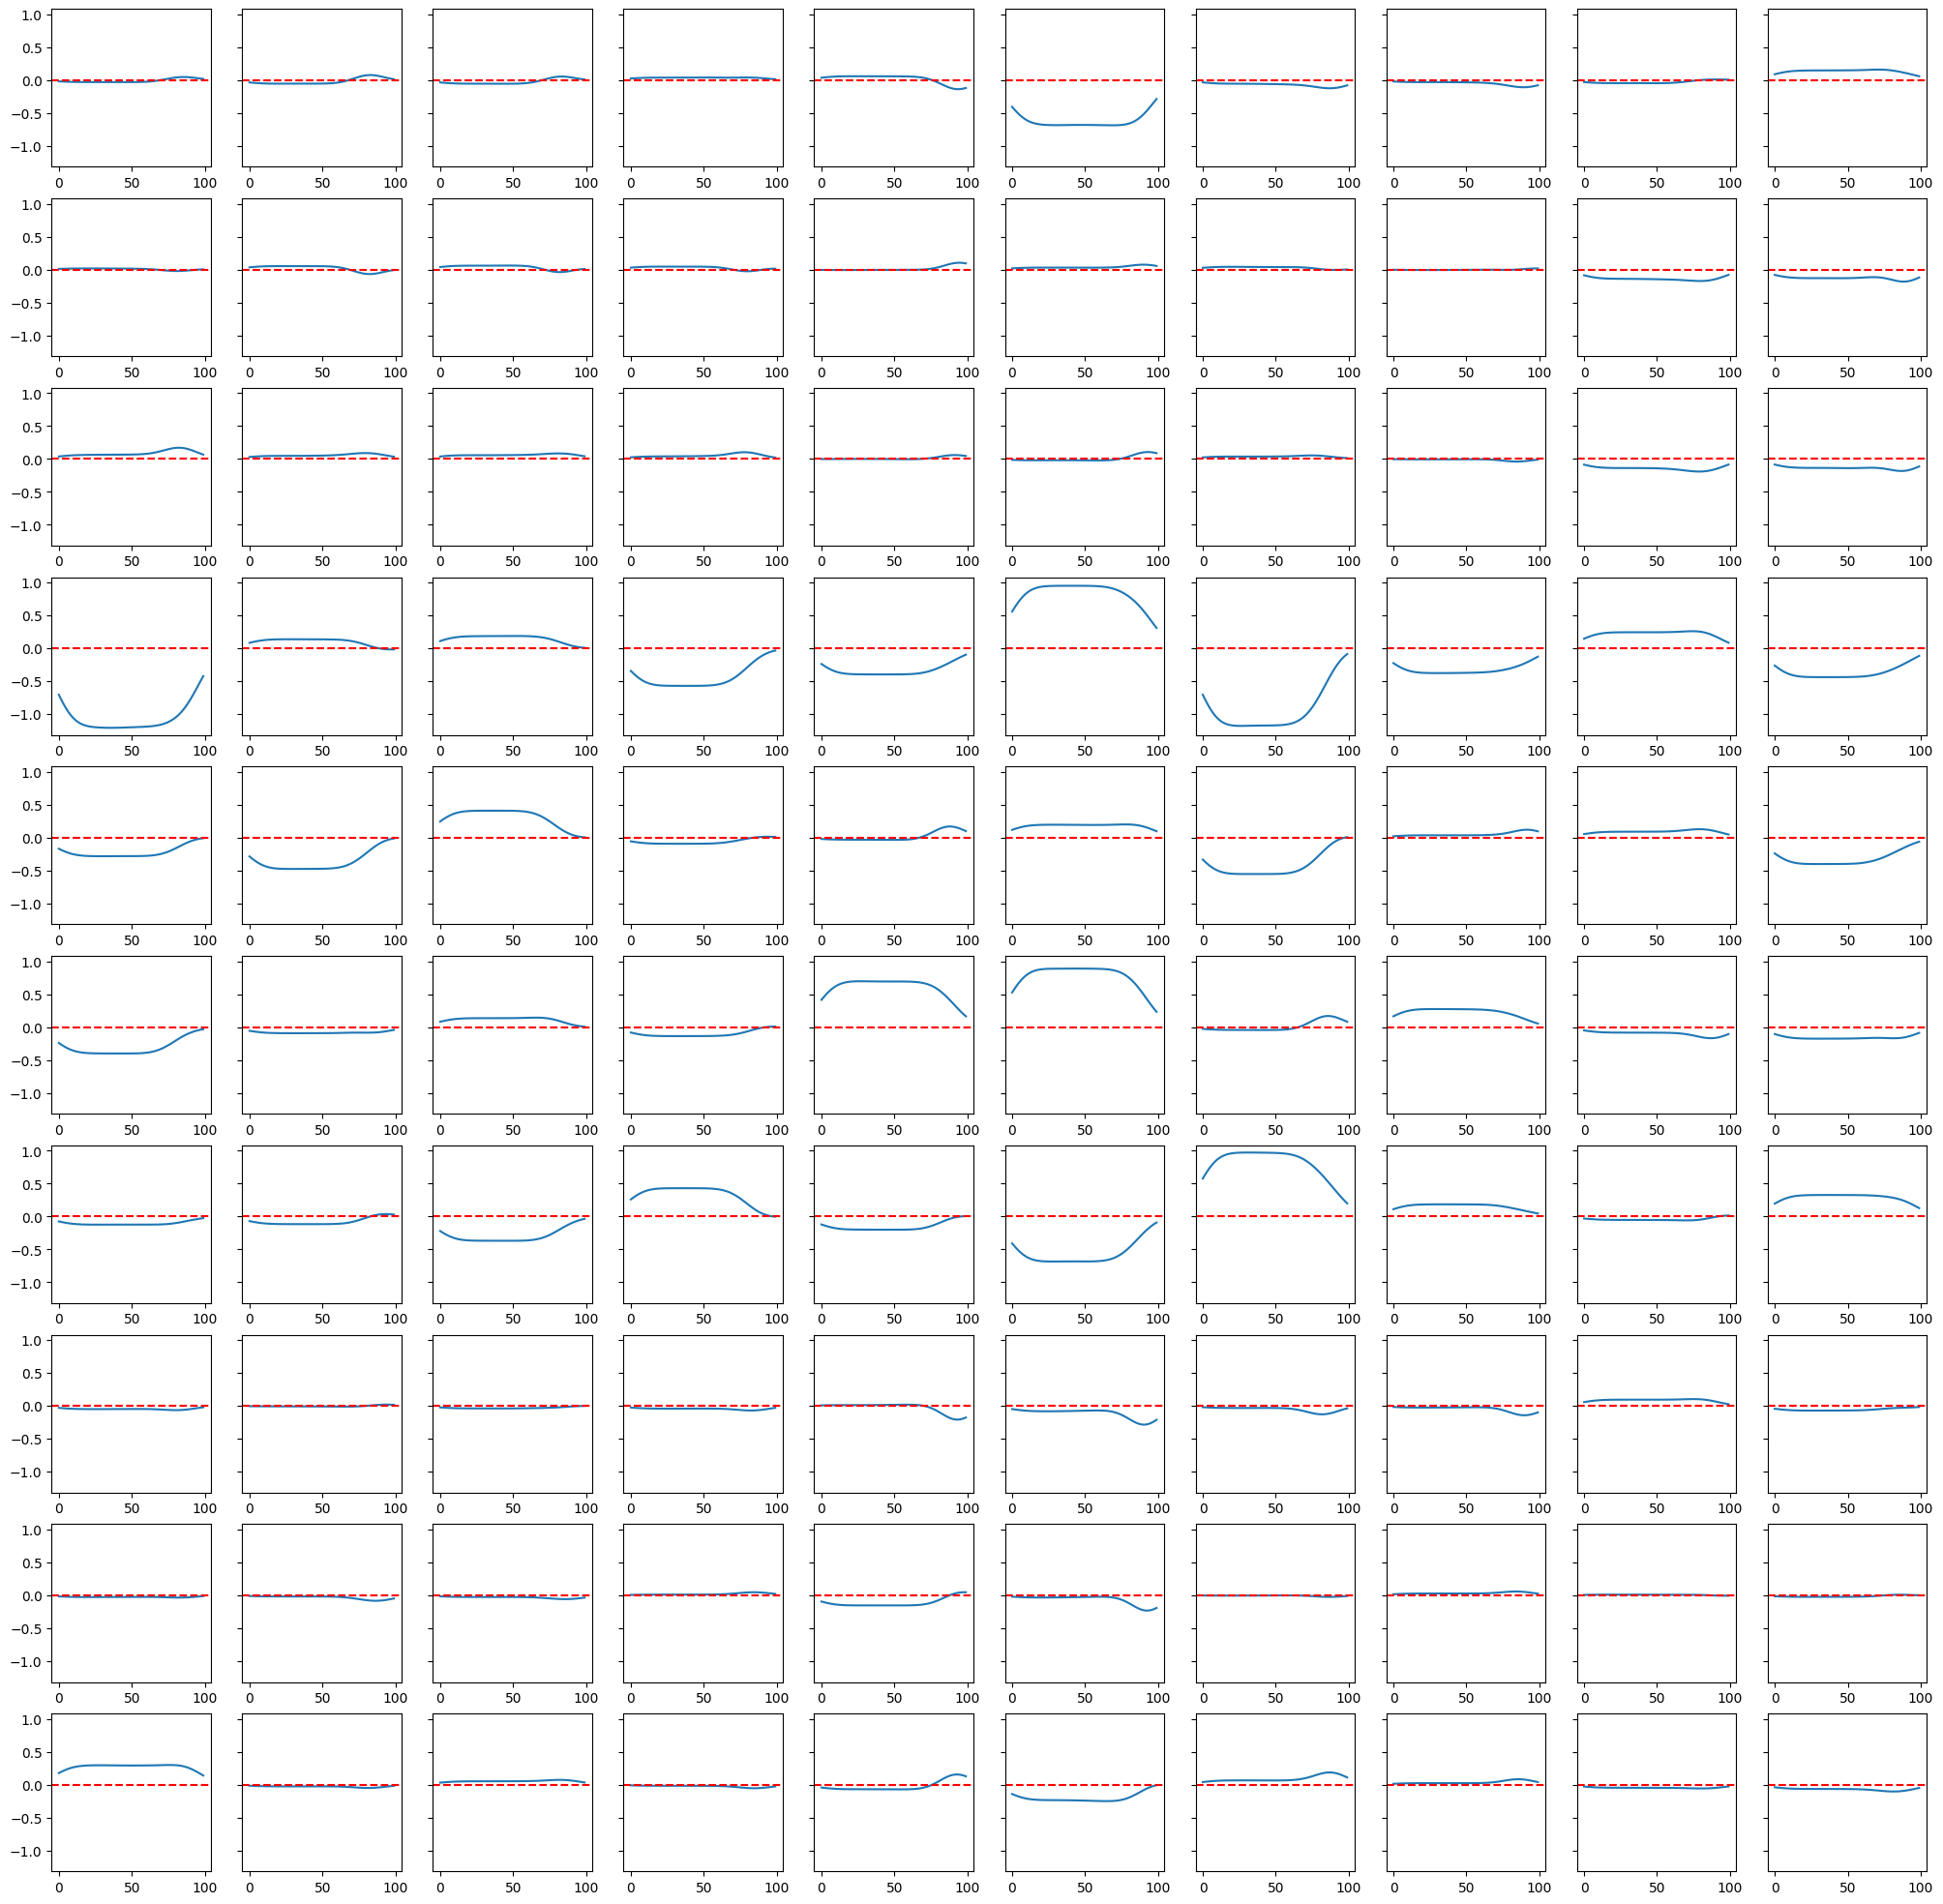

In [8]:
import matplotlib.pyplot as plt
weights =   params['deform_weights'].cpu().detach()
biases =    params['deform_biases'].cpu().detach()
stds =      params['deform_stds'].cpu().detach()

deforms = []
deformsx1 = []
for time in range(100):
    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
    deforms.append(deform) # Nx10 gaussians deformations
    deformsx1.append(deform[0,0])
fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
for i in range(10):
    for ii in range(10):
        ax[ii,i].plot([deforms[idx][i+91720//3,ii] for idx in range(len(deforms))])
        ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [9]:
torch.argmin(params['deform_stds'])

tensor(5635670, device='cuda:0')

In [10]:
params['deform_stds'].view(-1).shape

torch.Size([17362800])

In [11]:
maxs = np.array([deform.max() for deform in deforms])
maxs.max()

5.9373956

In [12]:
from GRN.models.conv_unet import GaussianRegressionNetwork
import torch

state_dict = torch.load('logs/GRN_6/checkpoint.pth',weights_only=False)
model_state_dict = state_dict['model']

model = GaussianRegressionNetwork()
model.load_state_dict(model_state_dict)

torch.save(model.state_dict(),'GRN/models/GRN_v1.pth')
